In [2]:
print('This notebook was prepared using:')

import os
import sys
print('python version %s' % sys.version)

import numpy as np
print('numpy version %s' % np.__version__)

import pandas as pd
print('pandas version %s' % pd.__version__)

import math
from math import isnan

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
print('matplotlib version %s' % matplotlib.__version__)

import re
import sys
import argparse
import scipy as sp
import random

from scipy import integrate
import scipy.interpolate as sp_interpolate
import statistics

from dataclasses import dataclass
import time as time_module

import simulation as sim
import importlib

# GitHub directories
HIV_DIR = 'data/HIV'
MPL_DIR = 'src/MPL'
SIM_DIR = 'data/simulation'
FIG_DIR = 'figures'

This notebook was prepared using:
python version 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
numpy version 1.24.2
pandas version 1.5.3
matplotlib version 3.7.1


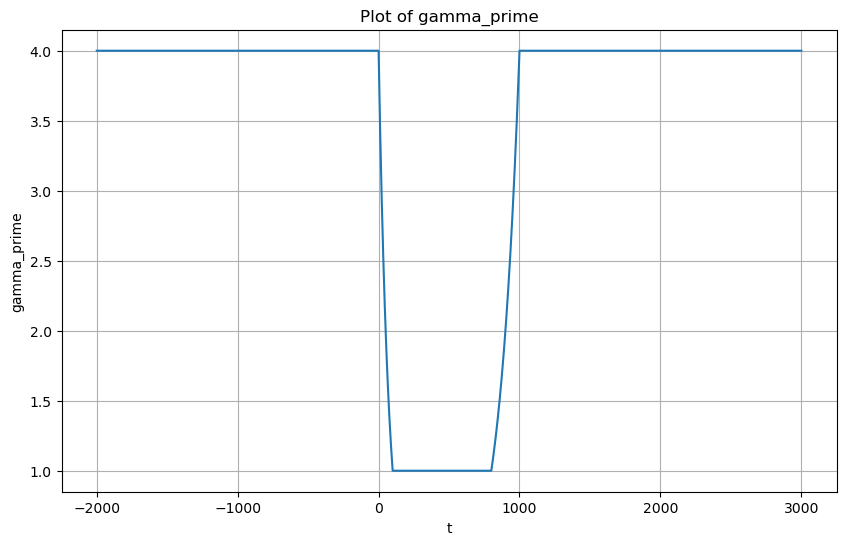

In [196]:
# extend the time range
TLeft   = int(round(times[-1]*2/10)*10) # time range added before the beginning time
TRight  = int(round(times[-1]*2/10)*10) # time range added after the ending time
etleft  = np.linspace(-TLeft,-40,int(TLeft/40)) # time added before the beginning time (dt=10)
etright = np.linspace(times[-1]+40,times[-1]+TRight,int(TRight/40))
ExTimes = np.concatenate((etleft, times, etright))

# individual site: gamma_2c, escape group and special site: gamma_2tv
# gamma 2 is also time varying, it is smaller at the boundary

gamma_t = np.zeros(len(ExTimes))
beta_1 = 4
beta_2 = 4
ratio_1 = 0.1
ratio_2 = 0.2
alpha1  = np.log(beta_1) / (ratio_1*1000)
alpha2  = np.log(beta_2) / (ratio_2*1000)

for t in range(len(ExTimes)):
    if t <= len(etleft):
        gamma_t[t] = beta_1
    elif t >= len(etleft)+len(times):
        gamma_t[t] = beta_2
    elif len(etleft) < t and t < len(etleft)+(len(times)-1)*ratio_1:
        tt = (t - len(etleft)) * 1
        gamma_t[t] = beta_1 * np.exp(-alpha1 * tt)
    elif len(etleft)+(len(times)-1)*(1 - ratio_2) < t and t < len(etleft)+len(times):
        tt = (t - len(etleft)) * 1 - (1 - ratio_2) * totalT
        gamma_t[t] = 1 * np.exp(alpha2 * tt)
    else:
        gamma_t[t] = 1


plt.figure(figsize=(10, 6))
plt.plot(ExTimes, gamma_t, label="gamma_prime")
plt.title("Plot of gamma_prime")
plt.xlabel("t")
plt.ylabel("gamma_prime")
plt.grid(True)
plt.show()



In [194]:
const_num = 6
output = '_ll_11'
# Neumann boundary condition
f = open('%s/simple/mpl_collected%s.csv'%(SIM_DIR,output),'w')
f.write('trajectory,ns,delta_t')
for i in range(const_num):
    f.write(',sc_%d'%i)
f.write('\n')

for k in range(100):
    name = str(k)
    data_full   = np.load('%s/simple/output%s/c_%s.npz'%(SIM_DIR,output,name), allow_pickle="True")
    sc_full     = data_full['selection']
    TimeVaryingSC = [np.average(sc_full[i]) for i in range(const_num)]
    f.write('%d,1000,1'%k)
    for i in range(const_num):
        f.write(',%f'%TimeVaryingSC[i])
    f.write('\n')
f.close()

In [189]:
ratio = 0.2
alpha  = np.log(beta) / (ratio*1000)
gamma =  np.exp(alpha * 150)
print(gamma)

2.8284271247461903


In [35]:
times = [0,2,5,6,10,12,15,18,25,32,40,80,85,88,90,92,93,95,96,97,98]
# extend the time range
theta = 0.1
TLeft   = int(round(times[-1]*theta/10)*10)
TRight  = int(round(times[-1]*theta/10)*10)
ex_gap  = int(theta*20)
etleft  = np.linspace(-TLeft,-ex_gap,int(TLeft/ex_gap))
etright = np.linspace(times[-1]+ex_gap,times[-1]+TRight,int(TRight/ex_gap))
ExTimes = np.concatenate((etleft, times, etright))

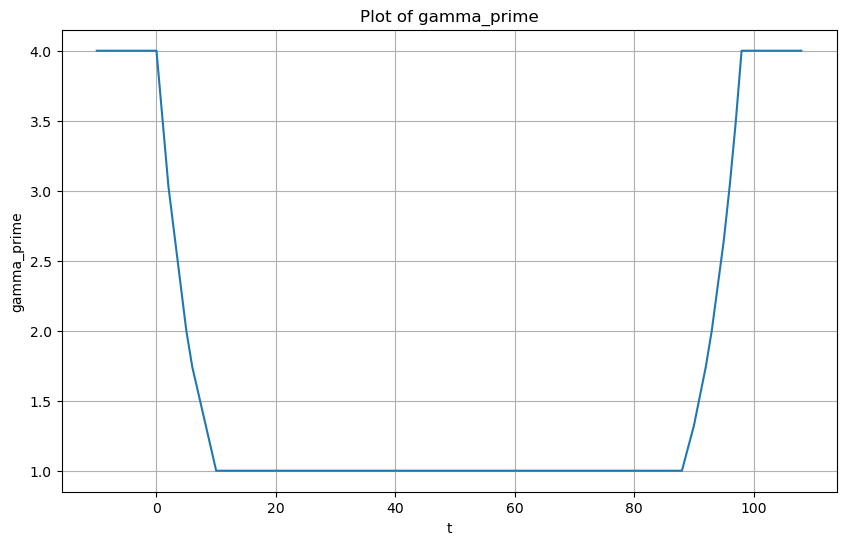

In [37]:
# regularization value gamma_1 and gamma_2

# gamma 2 is also time varying, it is larger at the boundary
gamma_t = np.zeros(len(ExTimes))
tv_range = int(round(times[-1]*0.1/10)*10)
alpha1  = np.log(4) / tv_range
alpha2  = np.log(4) / tv_range
for t in range(len(ExTimes)):
    if ExTimes[t] <= 0:
        gamma_t[t] = 4
    elif ExTimes[t] >= times[-1]:
        gamma_t[t] = 4
    elif 0 < ExTimes[t] and ExTimes[t] <= tv_range:
        gamma_t[t] = 4 * np.exp(-alpha1 * ExTimes[t])
    elif times[-1]-tv_range <= ExTimes[t] and ExTimes[t] < times[-1]:
        gamma_t[t] = 1 * np.exp(alpha2 * (ExTimes[t]-times[-1]+tv_range))
    else:
        gamma_t[t] = 1

plt.figure(figsize=(10, 6))
plt.plot(ExTimes, gamma_t, label="gamma_prime")
plt.title("Plot of gamma_prime")
plt.xlabel("t")
plt.ylabel("gamma_prime")
plt.grid(True)
plt.show()


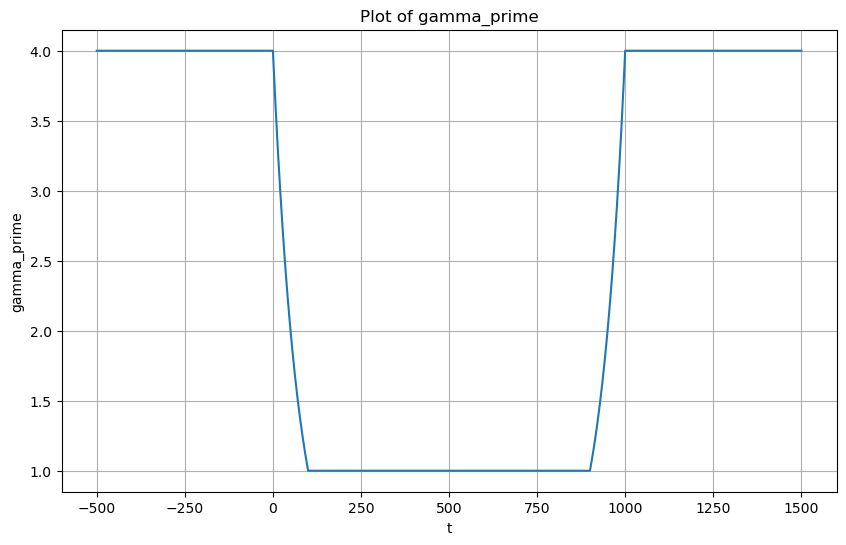

In [39]:
import numpy as np
import matplotlib.pyplot as plt

totalT = 1000
times = np.linspace(0,totalT,totalT+1)

TLeft   = int(round(times[-1]*0.5/10)*10) # time range added before the beginning time
TRight  = int(round(times[-1]*0.5/10)*10) # time range added after the ending time
etleft  = np.linspace(-TLeft,-5,int(TLeft/5)) # time added before the beginning time (dt=10)
etright = np.linspace(times[-1]+5,times[-1]+TRight,int(TRight/5))
ExTimes = np.concatenate((etleft, times, etright))


        
# 绘图
plt.figure(figsize=(10, 6))
plt.plot(ExTimes, gamma_t, label="gamma_prime")
plt.title("Plot of gamma_prime")
plt.xlabel("t")
plt.ylabel("gamma_prime")
plt.grid(True)
plt.show()

In [40]:
max(0,2)

2

In [52]:
interpolation = lambda a,b: sp_interpolate.interp1d(a,b,kind='linear')

def interpolator_x(single_freq, double_freq, current_times, result_times):
    single_freq_temp = np.zeros((len(result_times),x_length))
    double_freq_temp = np.zeros((len(result_times),x_length,x_length))

    for i in range(x_length):
        single_freq_temp[:,i] = interpolation(current_times, single_freq[:,i])(result_times)
        for j in range(x_length):
            double_freq_temp[:,i,j] = interpolation(current_times, double_freq[:,i,j])(result_times)

    return single_freq_temp, double_freq_temp

def interpolator_ex(escape_freq, current_times, result_times):
    if ne != 0:
        escape_freq_temp  = np.zeros((len(result_times),ne,seq_length,q))
    else: # if there is no escape group, return 0
        escape_freq_temp  = []

    for n in range(ne):
        for i in range(seq_length):
            for a in range(q):
                escape_freq_temp[:,n,i,a] = interpolation(current_times, escape_freq[:,n,i,a])(result_times)

    return escape_freq_temp

def interpolator_p(p_wt, p_mut_k, current_times, result_times):
    wt_temp    = np.zeros((len(result_times),ne))
    mut_k_temp = np.zeros((len(result_times),seq_length,3))
    # interpolation for wild type frequency
    for n in range(ne):
        wt_temp[:,n] = interpolation(current_times, p_wt[:,n])(result_times)

    # interpolation for frequency related to recombination part
    for i in range(seq_length):
        for j in range(3):
            mut_k_temp[:,i,j] = interpolation(current_times, p_mut_k[:,i,j])(result_times)
    
    return wt_temp, mut_k_temp

def diffusion_matrix_at_t(x,xx):
    x_length = len(x[0])
    C = np.zeros([len(x),x_length,x_length])
    for t in range(len(x)):
        for i in range(x_length):
            C[t,i,i] = x[t,i] - x[t,i] * x[t,i]
            for j in range(int(i+1) ,x_length):
                C[t,i,j] = xx[t,i,j] - x[t,i] * x[t,j]
                C[t,j,i] = xx[t,i,j] - x[t,i] * x[t,j]
    return C

def get_mutation_flux(x,ex,muVec):
    flux = np.zeros((len(x),x_length))
    for t in range(len(x)):
        for i in range(seq_length):
            for a in range(q):
                aa = int(muVec[i][a])
                if aa != -1:
                    for b in range(q):
                        bb = int(muVec[i][b])
                        if b != a:
                            if bb != -1:
                                flux[t,aa] +=  muMatrix[b][a] * x[t,bb] - muMatrix[a][b] * x[t,aa]
                            else:
                                flux[t,aa] += -muMatrix[a][b] * x[t,aa]
        for n in range(ne):
            for nn in range(len(escape_group[n])):
                for a in range(q):
                    WT = escape_TF[n][nn]
                    index = escape_group[n][nn]
                    if a not in WT:
                        for b in WT:
                            flux[t, x_length-ne+n] += muMatrix[b][a] * (1 - x[t,x_length-ne+n]) - muMatrix[a][b] * ex[t,n,index,a]
    return flux

# calculate recombination flux term
def get_recombination_flux(x,p_wt,p_mut_k,trait_dis):
    flux = np.zeros((len(x),x_length))
    for n in range(ne):
        for t in range(len(x)):
            fluxIn  = 0
            fluxOut = 0

            for nn in range(len(escape_group[n])-1):
                k_index = escape_group[n][0]+nn
                fluxIn  += trait_dis[n][nn] * p_wt[t][n]*p_mut_k[t][k_index][0]
                fluxOut += trait_dis[n][nn] * p_mut_k[t][k_index][1]*p_mut_k[t][k_index][2]

            flux[t,x_length-ne+n] = r_rate * (fluxIn - fluxOut)

    return flux

# calculate the difference between the frequency at time t and time t-1
def cal_delta_x(single_freq,times):
    delta_x = np.zeros((len(single_freq),x_length))   # difference between the frequency at time t and time t-1s
#     calculate by np.gradient function
#         for ii in range(x_length):
#             delta_x[:,ii] = np.gradient(single_freq.T[ii],times)
#     calculate manually
    for t in range(len(single_freq)-1):
        delta_x[t] = (single_freq[t+1] - single_freq[t])/(times[t+1]-times[t])

    # dt for the last time point, make sure the expected x[t+1] is less than 1
    dt_last = times[-1] - times[-2]
    for ii in range(x_length):
        if single_freq[-1,ii] + delta_x[-1,ii]*dt_last> 1:
            delta_x[-1,ii] = (1 - single_freq[-1,ii])/dt_last
        else:
            delta_x[-1,ii] = delta_x[-2,ii]

    return delta_x

In [103]:
tag = '703010131-3'
rawdata  = np.load('%s/rawdata/rawdata_%s.npz'%(HIV_DIR,tag), allow_pickle=True)
# information for individual sites
x            = rawdata['single_freq']
xx           = rawdata['double_freq']
ex           = rawdata['escape_freq']
muVec        = rawdata['muVec']
sample_times = rawdata['sample_times']
times        = rawdata['times']
time_step    = rawdata['time_step']
seq_length   = rawdata['seq_length']

# information for escape group
p_wt         = rawdata['p_wt_freq']
p_mut_k      = rawdata['p_mut_k_freq']
p_sites      = rawdata['special_sites']
escape_group = rawdata['escape_group'].tolist()
escape_TF    = rawdata['escape_TF'].tolist()
trait_dis    = rawdata['trait_dis'].tolist()

ne           = len(escape_group)
x_length     = len(x[0])
print(x_length)

217


In [104]:
print(x[:,18])

[1.         1.         1.         0.83333333 1.         1.
 1.         1.         1.        ]


In [56]:
NUC = ['-', 'A', 'C', 'G', 'T']
q = len(NUC)
muMatrix = np.loadtxt("%s/Zanini-extended.dat"%HIV_DIR)

# after interpolation, calculate all the required data
single_freq, double_freq = interpolator_x(x, xx, sample_times, times)
escape_freq              = interpolator_ex(ex, sample_times, times)
p_wt_freq, p_mut_k_freq  = interpolator_p(p_wt, p_mut_k,sample_times, times)

In [58]:
r_rate = 1.4e-5
# covariance matrix, flux term and delta_x
covariance_n = diffusion_matrix_at_t(single_freq, double_freq)
covariance   = np.swapaxes(covariance_n, 0, 2)
flux_mu      = get_mutation_flux(single_freq,escape_freq,muVec)         # mutation part
flux_rec     = get_recombination_flux(single_freq,p_wt_freq,p_mut_k_freq,trait_dis) # recombination part
delta_x      = cal_delta_x(single_freq,times)

# extend the time range
TLeft   = int(round(times[-1]*theta/10)*10)
TRight  = int(round(times[-1]*theta/10)*10)
ex_gap  = int(theta*20)
etleft  = np.linspace(-TLeft,-ex_gap,int(TLeft/ex_gap))
etright = np.linspace(times[-1]+ex_gap,times[-1]+TRight,int(TRight/ex_gap))
ExTimes = np.concatenate((etleft, times, etright))

In [61]:
# regularization value gamma_1 and gamma_2
# individual site: gamma_1s, escape group: gamma_1p
gamma_1s = round(10/sample_times[-1],3) # constant MPL gamma value / max time
gamma_1p = gamma_1s/10
gamma1   = np.ones(x_length)*gamma_1s
for n in range(ne):
    gamma1[x_length-ne+n] = gamma_1p

# gamma 2 is also time varying, it is larger at the boundary
gamma_t = np.zeros(len(ExTimes))
tv_range = max(int(round(times[-1]*0.1/10)*10),1)
alpha1  = np.log(4) / tv_range
alpha2  = np.log(4) / tv_range
for t in range(len(ExTimes)):
    if ExTimes[t] <= 0:
        gamma_t[t] = 4
    elif ExTimes[t] >= times[-1]:
        gamma_t[t] = 4
    elif 0 < ExTimes[t] and ExTimes[t] <= tv_range:
        gamma_t[t] = 4 * np.exp(-alpha1 * ExTimes[t])
    elif times[-1]-tv_range <= ExTimes[t] and ExTimes[t] < times[-1]:
        gamma_t[t] = 1 * np.exp(alpha2 * (ExTimes[t]-times[-1]+tv_range))
    else:
        gamma_t[t] = 1

gamma_2c = 200
gamma_2tv = 1000000
# individual site: gamma_2c, escape group and special site: gamma_2tv
gamma2 = np.ones((x_length,len(ExTimes)))*gamma_2c
for n in range(ne):
    gamma2[x_length-ne+n] = gamma_t * gamma_2tv
for p_site in p_sites: # special site - time varying
    for qq in range(len(NUC)):
        index = int (muVec[p_site][qq]) 
        if index != -1:
            gamma2[index] = gamma_t * gamma_2tv


In [66]:
# solve the bounadry condition ODE to infer selections
def fun(a,b):
    """ Function defining the right-hand side of the system of ODE's"""
    b_1                 = b[:x_length,:]   # the actual selection coefficients
    b_2                 = b[x_length:,:]   # the derivatives of the selection coefficients, s'
    result              = np.zeros((2*x_length,len(a))) # The RHS of the system of ODE's
    result[:x_length]   = b_2       # sets the derivatives of the selection coefficients 'b_1', equal to s'
    mat_prod            = np.sum(covariance[:,:,:len(a)] * b_1[:,len(etleft):len(etleft)+len(times)], 1)

    for t in range(len(a)): # right hand side of second half of the ODE system
        # within the time range
        if len(etleft) <= t < len(etleft)+len(times):
            tt = t - len(etleft)
            for i in range(x_length):
                result[x_length+i,t] = (mat_prod[i,tt] + gamma1[i] * b_1[i,t] + flux_mu[tt,i] + flux_rec[tt,i] - delta_x[tt,i]) / gamma2[i,t]

        # outside the time range, no selection strength
        else:
            for i in range(x_length):
                result[x_length+i,t] = gamma1[i] * b_1[i,t] / gamma2[i,t]

    return result

def bc(b1,b2):
    return np.ravel(np.array([b1[x_length:],b2[x_length:]])) # s' = 0 at the extended endpoints

ss_extend = np.zeros((2*x_length,len(ExTimes)))

solution = sp.integrate.solve_bvp(fun, bc, ExTimes, ss_extend, max_nodes=10000, tol=1e-3)

selection_coefficients = solution.sol(ExTimes)
# removes the superfluous part of the array and only save the real time points
desired_coefficients   = selection_coefficients[:x_length,len(etleft):len(etleft)+len(times)]



In [79]:
print(times)
print(x[:,-3])

[  0   5  10  15  21  28  34  39  44  49  54  59  63  68  73  78  83  88
  91  96 101 106 111 116 121 126 131 136 141 146 151 156 161 166 171 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 273 278 283 288 293 298 303 308 313 318 323 328 333]
[0.03030303 0.         0.         0.         0.         0.
 0.         0.         0.        ]


In [70]:
print(len(desired_coefficients[-1]))

68


In [64]:
print(times)

[  0   5  10  15  21  28  34  39  44  49  54  59  63  68  73  78  83  88
  91  96 101 106 111 116 121 126 131 136 141 146 151 156 161 166 171 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 273 278 283 288 293 298 303 308 313 318 323 328 333]


In [42]:
importlib.reload(sim)

# Load the simulation data
data         = np.loadtxt("%s/example/example-0.dat"%(SIM_DIR))
escape_group = sim.read_file('example','traitsite-0.dat')
trait_dis    = sim.read_file('example','traitsite-0.dat')

p_sites      = [13,18]
# Calculate covariance matrix
sVec,nVec,eVec = sim.getSequence(data,escape_group)
seq_length     = len(sVec[0][0])      # sequence length
ne             = len(escape_group) # trait group

muVec    = -np.ones(seq_length)
x_length = 0
for i in range(seq_length):
    allele_count = np.zeros(len(sVec))
    allele_count = [np.sum([(sVec[t][k][i]==1)*nVec[t][k] for k in range(len(sVec[t]))]) for t in range(len(sVec))]
    if max(allele_count) / np.sum(nVec[0]) >= 0:
        muVec[i] = x_length
        x_length += 1
x_length      += ne


In [60]:
def get_allele_frequency(sVec,nVec,eVec,muVec):

    x  = np.zeros((len(nVec),x_length))           # single allele frequency
    xx = np.zeros((len(nVec),x_length,x_length))  # pair allele frequency
    for t in range(len(nVec)):
        pop_size_t = np.sum([nVec[t]])
        # individual locus part
        for i in range(seq_length):
            aa = int(muVec[i])
            if aa != -1:
                x[t,aa] = np.sum([sVec[t][k][i] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
            for j in range(int(i+1), seq_length):
                bb = int(muVec[j])
                if bb != -1:
                    xx[t,aa,bb] = np.sum([sVec[t][k][i] * sVec[t][k][j] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
                    xx[t,aa,bb] = np.sum([sVec[t][k][i] * sVec[t][k][j] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
        # escape part
        for n in range(ne):
            aa      = x_length-ne+n
            x[t,aa] = np.sum([eVec[t][k][n] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
            for m in range(int(n+1), ne):
                bb          = x_length-ne+m
                xx[t,aa,bb] = np.sum([eVec[t][k][n] * eVec[t][k][m] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
                xx[t,bb,aa] = np.sum([eVec[t][k][n] * eVec[t][k][m] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
            for j in range(seq_length):
                bb = int(muVec[j])
                if bb != -1:
                    xx[t,bb,aa] = np.sum([sVec[t][k][j] * eVec[t][k][n] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
                    xx[t,aa,bb] = np.sum([sVec[t][k][j] * eVec[t][k][n] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
    return x,xx

# calculate escape frequency (binary case)
def get_escape_fre_term(sVec,nVec):
    ex  = np.zeros((len(nVec),ne,seq_length))
    for t in range(len(nVec)):
        pop_size_t = np.sum([nVec[t]])
        for k in range(len(sVec[t])):
            for n in range(ne):
                n_mutations = 0
                for nn in escape_group[n]:
                    if sVec[t][k][nn] != 0:
                        n_mutations += 1
                        site = nn
                if n_mutations == 1:
                    ex[t,n,site] += nVec[t][k]
        ex[t,:,:] = ex[t,:,:] / pop_size_t
    return ex

x,xx         = get_allele_frequency(sVec,nVec,eVec,muVec) 
covar_int    = sim.diffusion_matrix_at_t(x,xx,x_length)


In [79]:
gamma_1s      = 10/500 # gamma_s/time points
gamma_1p      = gamma_1s/10
gamma_2c      = 1000000       # 1000000
gamma_2tv     = 500

# regularization value gamma_1 and gamma_2
# individual site: gamma_1s, escape group: gamma_1p
gamma1_m = np.zeros((x_length,x_length))
for i in range(x_length):
    gamma1_m[i][i] = gamma_1s
for n in range(ne):
    nn = x_length-ne+n
    gamma1_m[nn][nn] = gamma_1p

# individual site: gamma_2c, escape group and special site: gamma_2tv
gamma2 = np.ones(x_length)*gamma_2c
for n in range(ne):
    gamma2[x_length-ne+n] = gamma_2tv
for i in range(len(p_sites)): # special site - time varying
    index = int (muVec[p_sites[i]]) 
    if index != -1:
        gamma2[index] = gamma_2tv

A_matrix = np.zeros((x_length,x_length))
for i in range(x_length):
    for j in range(x_length):
        A_matrix[i][j] = (np.average(covar_int[:,i,j])+gamma1_m[i,j])/gamma2[i]

print(A_matrix[0,0])

1.6262595409181634e-07


In [46]:
d_value, Q_matrix = np.linalg.eig(A_matrix) # calculate the eigenvalues d_value and eigenvectors Q_matrix
D_matrix = np.diag(d_value) # D is a diagonal matrix with the eigenvalues of A


In [4]:
tag = '703010131-3'
rawdata = np.load('%s/rawdata/rawdata_%s.npz'%(HIV_DIR,tag), allow_pickle="True")
x            = rawdata['single_freq']
print(len(x[0]))

241
